In [1]:
import os
import datetime as dt
from pytz import timezone

import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import models,transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

from dataset import MaskDataset, AddGaussianNoise, MaskDatasetForSplit, label_encoder, label_decoder, TestDataset
from models import Pretrained_Model, get_pre_trained

In [2]:
models_info = ['Mask', 'Gender', 'Age']

In [3]:
def load_model(key, model_path, device):
    if key == 'Gender':
        model = Pretrained_Model('resnet18', 2)
    else:
        model = Pretrained_Model('resnet18', 3)
    model_path_ = os.path.join(model_path, f'best_{key}.pth')
    print(model)
    model.load_state_dict(torch.load(model_path_, map_location=device))
    print('load_state_dict completed')
    return model

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model_path = f'../model/split'
models_ = [load_model(types, model_path, device) for types in models_info]

Pretrained_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [5]:
data_dir = '../../input/data/eval'
img_root = os.path.join(data_dir, 'images')
info_path = os.path.join(data_dir, 'info.csv')
info = pd.read_csv(info_path)

img_paths = [os.path.join(img_root, img_id) for img_id in info.ImageID]

In [6]:
mean=(0.485, 0.456, 0.406); std=(0.229, 0.224, 0.225)
val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

test_dataset = TestDataset(img_paths=img_paths,transforms=val_transform)

In [7]:
test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [8]:
models_[0]

Pretrained_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [9]:
print("Calculating inference results..")
output_dir = '../output'

now = dt.datetime.now().astimezone(timezone('Asia/Seoul'))
formattedDate = now.strftime("%m%d_%H시%M분")
preds = [[],[],[]]
ans = []
for i, model in enumerate(models_):
    model.to(device)
    with torch.no_grad():
        for idx, images in enumerate(tbar := tqdm(test_loader)):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            preds[i].extend(pred.cpu().numpy())
for x,y,z in zip(*preds):
    ans.append(label_encoder((x,y,z)))

In [11]:
print(ans[:10])
info['ans'] = ans

[13, 1, 13, 13, 12, 0, 7, 4, 4, 3]


In [10]:
save_path = os.path.join(output_dir, f'split_{formattedDate}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")

Inference Done! Inference result saved at ../output/split_0228_14시29분.csv


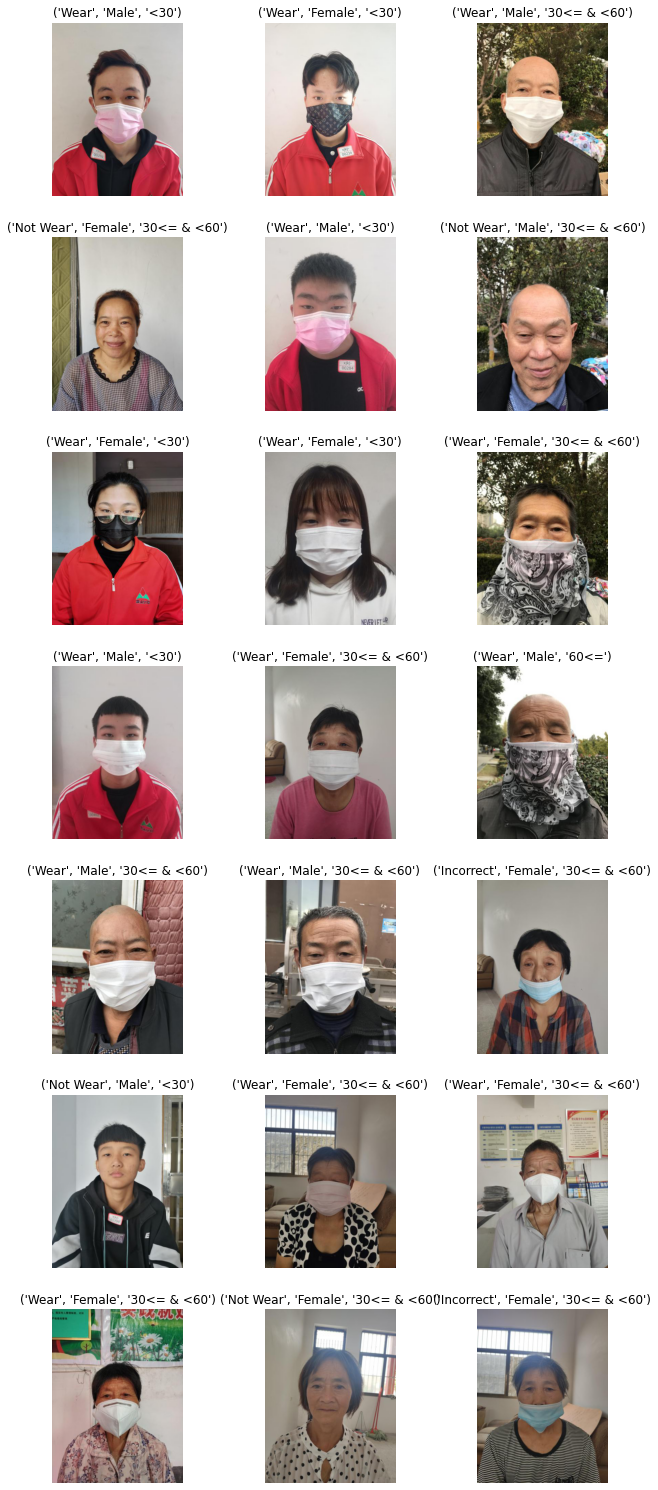

In [15]:
N = 21

fig, ax = plt.subplots(N//3, 3, figsize=(3*3, N))
idxs = np.random.choice(len(info), N)
ax = ax.flatten()
for idx, data_idx in enumerate(idxs):
    pred = info['ans'].iloc[data_idx]
    image_path = f"{data_dir}/images/{info['ImageID'].iloc[data_idx]}"
    image = plt.imread(image_path)
    
    pred = label_decoder(pred)
    ax[idx].set_title(f'{pred}')
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.tight_layout()